# CAdam optimizer demo

In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os, glob
#import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (12.0, 7.0)

from typing import *
import torch
from torch import Tensor
import sys, os, shutil
import pandas as pd

ROOT_PROJECT =  os.path.join(os.path.normpath(os.path.join(os.getcwd(), "../"))) 
sys.path[0] = ROOT_PROJECT

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from custom_optimizer.cadam import CAdam

### Problem definition

We consider the following nested-function $J: \mathbb{R}^2 \to \mathbb{R}$ to maximise:

$$J(X) = f\left(\mathbb{E}_{w\sim \mathbb{U}\{1, 2\}}\left[g_w(X)\right]\right)$$
where
$$g_w(X) = \begin{pmatrix} X_1 \mathbb{1}_{w=1} & X_2 \mathbb{1}_{w=2} \end{pmatrix}^\top \in \mathbb{R}^2, \qquad f(Y) = \cos(Y_1)  - |\sin(Y_2) - 0.2|$$
on the domain $[-2, 2]^2$

To optimise this compositional objective function $J$ we can use [`CAdam` optimiser ](https://arxiv.org/pdf/2002.03755.pdf).

To do so, we simply need to define $f$ and an oracle that can be queried to estimate inner function value and gradient.

In [3]:
n_samples = 10

def oracle_g(X):
    aux = np.random.randint(0, n_samples + 1)
    Y = torch.zeros(X.shape)
    Y[..., 0] = aux * X[..., 1] * X[..., 0]
    Y[..., 1] = (n_samples - aux) * X[..., 1]
    return Y / n_samples

def f(Y):
    return torch.cos(Y[..., 0])   - (torch.sin(Y[..., 1])-.2).abs()

# Exact expression for inner expected value is known for this toy example so we will use it to assess 
# the performance of the optimisation 
def expected_g(X):
    """ Expected value of g_w(X)"""
    z = torch.zeros(X.shape)
    z[..., 0] = X[..., 0] * X[..., 1]
    z[..., 1] = X[..., 1]
    return X / 2


bounds = torch.zeros(2, 2)
bounds[0] = -2
bounds[1] = 2

### Optimisation

In [4]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

# random initialisation
X = torch.rand(2).mul(4).add(-2).requires_grad_(True)
Y = oracle_g(X).detach().requires_grad_(True)

optimizer = CAdam(params=(dict(params=X), dict(params=Y)),lr=.2)

# Keep `X` in the domain 
proj_x = lambda x: x.minimum(bounds[1]).maximum(bounds[0])

##### Main loop

In [5]:
Xs = []
for step in range(1000):
    n_samples = int((1 + step) ** (4 /5)) 
    optimizer.zero_grad()
    f_Y = - f(Y)
    f_Y.backward()
    g_X = optimizer.step(oracle_g=oracle_g)
    X.data = proj_x(X).data
    if step % 5 == 0:
        with torch.no_grad():
            value_function = f(g_X).item()
#         print(f'{step: 5d}: f(E[g(X)]) ≈ {value_function:.2f} {X, Y}')
        Xs.append(X.detach().clone().numpy())
Xs = np.array(Xs)

### Visualize results

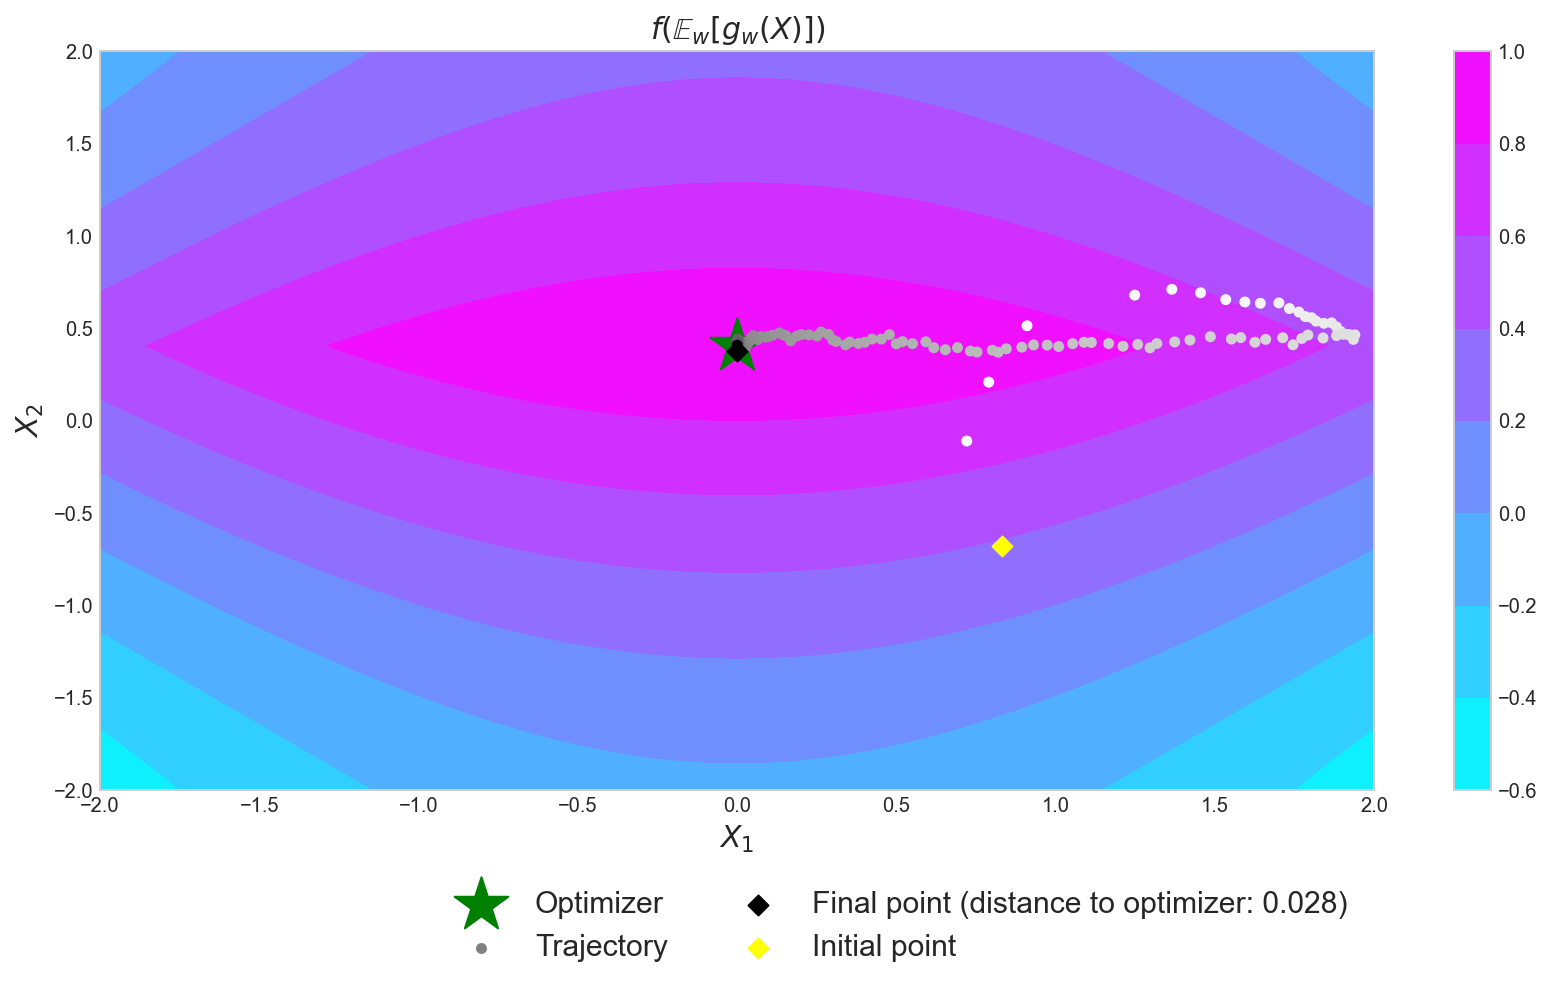

In [74]:
n = 1000
u = v = np.linspace(-2, 2, n)
U, V = np.meshgrid(u, v)
Z = torch.zeros(*U.shape, 2)
Z[..., 0] = torch.tensor(U)
Z[..., 1] = torch.tensor(V)
z = f(expected_g(Z)).numpy()
optim_ind = np.unravel_index(z.argmax(), z.shape)
func_optimizer = torch.tensor([U[optim_ind], V[optim_ind]])

plt.contourf(U, V, z, cmap=plt.cm.cool)
plt.colorbar()
plt.title('$f(\mathbb{E}_w[g_w(X)])$', fontsize=15)
plt.xlabel('$X_1$', fontsize=15)
plt.ylabel('$X_2$', fontsize=15)
plt.scatter(func_optimizer[0], func_optimizer[1], marker='*', s=800, c='g', label='Optimizer')
plt.scatter([], [], c='grey', s=20, label='Trajectory')
dist_to_optim = np.linalg.norm(func_optimizer.numpy() - Xs[-1])
plt.scatter(df.x1, df.x2, s=20, c=df.index, cmap=plt.cm.binary)
plt.scatter(Xs[-1, 0], Xs[-1,1], c='k', s=50, marker='D', label=f'Final point (distance to optimizer: {dist_to_optim:.3f})')
plt.scatter(Xs[0, 0], Xs[0,1], c='yellow', s=50, marker='D', label=f'Initial point')
plt.legend(fontsize=15, bbox_to_anchor=[0.5, -.6, .5,.5], ncol=2)
plt.tight_layout()
plt.show()